In [2]:
from collections import defaultdict
import numpy as np
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
%matplotlib inline

# Support Vector Machines
## Classification Using SVM
Load dataset. We will use w1a dataset from LibSVM datasets https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

The original optimization problem for the Support Vector Machine (SVM) is given by
\begin{equation}\label{eq:primal}
  \min_{w \in R^d} \  \sum_{i=1}^n \ell(y_i A_i^\top w) + \frac\lambda2 \|w\|^2
\end{equation}
where $\ell : R\rightarrow R$, $\ell(z) := \max\{0,1-z\}$ is the hinge loss function.
Here for any $i$, $1\le i\le n$, the vector $A_i\in R^d$ is the $i$-th data example, and $y_i\in\{\pm1\}$ is the corresponding label.
  
The dual optimization problem for the SVM is given by 
\begin{equation}\label{eq:dual}
 \max_{\boldsymbol{\alpha} \in R^n } \  \alpha^\top\boldsymbol{1} - \tfrac1{2\lambda} \alpha^\top Y A A^\top Y\alpha
 \text{    such that    $0\le \alpha_i \le 1  \ \forall i$}
\end{equation}
where $Y := \mathop{diag}(y)$, and $A\in R^{n \times d}$ again collects all $n$ data examples as its columns. 

Note that $w$ can be derived from $\alpha$ as
\begin{equation}
    w(\alpha) = \frac{1}{\lambda} A^\top Y \alpha.
\end{equation}

In [4]:
DATA_TRAIN_PATH = 'data/w1a'

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
print(y.shape, A.shape)

(2477,) (2477, 300)


## Prepare cost and prediction functions

In [14]:
def calculate_primal_objective(y, A, w, lambda_):
    """
    Compute the full cost (the primal objective), that is loss plus regularizer.
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    w: Model weights, shape = (num_features)
    return: scalar value
    """
    # ***************************************************
    s = 0
    for i in range(len(y)):
        loss = max(0, 1 - y[i] * (A[i].T @ w))
        s += loss
    w2 = np.sum(w ** 2)
    
    obj = s + lambda_ / 2 * w2
    # ***************************************************
    return obj

In [25]:
def calculate_accuracy(y, A, w):
    """
    Compute the training accuracy on the training set (can be called for test set as well).
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    w: Model weights, shape = (num_features)
    return: scalar value
    """
    # ***************************************************
    # compute predictions
    pred = A @ w
    # correct predictions to be -1 or 1
    for i in range(len(pred)):
        if pred[i] > 0:
            pred[i] = 1
        else:
            pred[i] = -1
        
    # compute accuracy
    acc = np.mean(pred == y)
    # ***************************************************
    return acc

## Coordinate Descent (Ascent) for SVM

Compute the closed-form update for the i-th variable alpha, in the dual optimization problem, given alpha and the current corresponding w.


Hints: 
- Differentiate the dual objective with respect to one `alpha[i]`.
- Set the derivative to zero to compute a new `alpha[i]`.
- Make sure the values of alpha stay inside a `[0, 1]` box.
- You can formulate the update as `alpha[i] = projection(alpha[i] + lambda_ * (some update))`.
- You can test the correctness of your implementation by checking if the difference between the dual objective and primal objective goes to zero. This difference, the duality gap, should get smaller than 10 in 700000 iterations.

In [31]:
def calculate_coordinate_update(y, A, lambda_, alpha, w, i):
    """
    Compute a coordinate update (closed form) for coordinate i.
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    lambda_: Regularization parameter, scalar
    alpha: Dual variables, shape = (num_examples)
    w: Model weights, shape = (num_examples)
    i: Index of the entry of the dual variable 'alpha' that is to be updated
    return: New weights w (shape (num_features)), New dual variables alpha (shape (num_examples))
    """
    # calculate the update of coordinate at index=n.
    a_i, y_i = A[i], y[i]
    old_alpha_i = np.copy(alpha[i])
    
    # ***************************************************
    C = old_alpha_i + lambda_ * ((1 - y_i * a_i.T @ w)/(a_i.T @ a_i))
    if C < 0: C = 0
    if C > 1: C = 1
    alpha[i] = C

    # update w
    w += (alpha[i] - old_alpha_i) * y_i * a_i * (1/lambda_)
    # ***************************************************

    return w, alpha

In [8]:
def calculate_dual_objective(y, A, w, alpha, lambda_):
    """
    Calculate the objective for the dual problem.
    Follow the formula given above.
    y: +1 or -1 labels, shape = (num_examples)
    A: Dataset matrix, shape = (num_examples, num_features)
    alpha: Dual variables, shape = (num_examples)
    lambda_: Regularization parameter, scalar
    return: Scalar value
    """
    # ***************************************************
    w2 = np.sum(w ** 2)
    obj = np.sum(alpha) - lambda_/2 * w2
    # ***************************************************
    return obj

In [32]:
def coordinate_descent_for_svm_demo(y, A, trace=False):
    max_iter = 1000000
    lambda_ = 0.01
    history = defaultdict(list) if trace else None
    
    num_examples, num_features = A.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    
    for it in range(max_iter):
        # i = sample one data point uniformly at random from the columns of A
        i = random.randint(0,num_examples-1)
        
        w, alpha = calculate_coordinate_update(y, A, lambda_, alpha, w, i)
            
        if it % 100000 == 0:
            # primal objective
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, A, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value
            
            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
        if it % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            if trace:
                history["objective_function"] += [primal_value]
                history['iter'].append(it)

            
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w)))
    return history

history_cd = coordinate_descent_for_svm_demo(y, A, trace=True)

iteration=0, primal:2198.07161, dual:0.00018, gap:2198.07143


c:\users\melanija\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


iteration=100000, primal:279.61403, dual:216.25006, gap:63.36397
iteration=200000, primal:263.39900, dual:222.35389, gap:41.04512
iteration=300000, primal:244.70078, dual:223.61763, gap:21.08315
iteration=400000, primal:237.81812, dual:224.60328, gap:13.21483
iteration=500000, primal:245.41629, dual:225.51759, gap:19.89869
iteration=600000, primal:241.74883, dual:225.98354, gap:15.76530
iteration=700000, primal:235.64178, dual:226.36782, gap:9.27396
iteration=800000, primal:235.74450, dual:226.68425, gap:9.06025
iteration=900000, primal:237.35067, dual:226.99495, gap:10.35572
training accuracy = 0.994751715785224


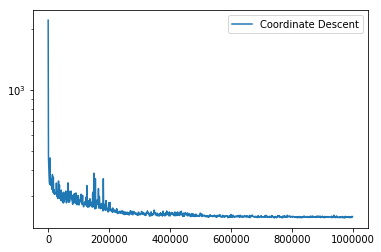

In [66]:
# plot training curve
plt.plot(history_cd["iter"], history_cd["objective_function"], label="Coordinate Descent")
plt.yscale('log')
plt.legend()

# Stochastic gradient descent for SVM

Let's now compare it with SGD on original problem for the SVM. In this part, you will implement stochastic gradient descent on the primal SVM objective. The stochasticity comes from sampling data points.

In [37]:
def compute_stoch_gradient_svm(A_sample, b_sample, lambda_, w_t, num_data_points):
    """
    Calculate stochastic gradient over A_batch, b_batch.
    A_sample: A data sample, shape=(num_features)
    b_sample: Corresponding +1 or -1 label, scalar
    w_t: Model weights, shape=(num_features)
    num_data_points: Total size of the dataset, scalar integer
    """
    # ***************************************************
    z = A_sample.dot(w_t) * b_sample
    if z < 1:
        gradient = (lambda_ * w_t) - (num_data_points * b_sample * A_sample)
    else:
        gradient = (lambda_ * w_t)
    # ***************************************************
    return gradient.reshape(-1)

In [38]:
def stochastic_gradient_descent_svm_demo(A, b, gamma, batch_size=1, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 1000000
    lambda_ = 0.01
    
    w_t = np.zeros(num_features)
    
    current_iter = 0
    while (current_iter < max_iter):
        i = random.randint(0,num_data_points - 1)
        b_batch, A_batch = b[i], A[i]
        gradient = compute_stoch_gradient_svm(A_batch, b_batch, lambda_, w_t, num_data_points)
        w_t = w_t - gamma * gradient
        if current_iter % 100000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, lambda_)
            print('iteration=%i, primal:%.5f'%(
                    current_iter, primal_value))
        if current_iter % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
        current_iter += 1
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w_t)))
    return history


Try different stepsizes and find the best one

In [43]:
lrs = [0.1, 0.01, 0.05, 0.001, 0.0005]
results = []
for lr in lrs:
    print('Running SGD with lr=', lr)
    sgd = stochastic_gradient_descent_svm_demo(A, y, lr, trace=True)
    results.append(sgd)
    print('---------------------------------------------')

Running SGD with lr= 0.1
iteration=0, primal:2477.00000
iteration=100000, primal:110097.59283
iteration=200000, primal:66169.28576
iteration=300000, primal:60418.10744
iteration=400000, primal:66759.96304
iteration=500000, primal:51609.27102
iteration=600000, primal:56694.14760
iteration=700000, primal:54628.00356
iteration=800000, primal:59701.83805
iteration=900000, primal:62832.66969
training accuracy = 0.9604360113039968
---------------------------------------------
Running SGD with lr= 0.01
iteration=0, primal:2704.13212
iteration=100000, primal:2997.47830
iteration=200000, primal:2902.55030
iteration=300000, primal:2608.37200
iteration=400000, primal:2990.86377
iteration=500000, primal:3821.56364
iteration=600000, primal:3999.55021
iteration=700000, primal:2648.27864
iteration=800000, primal:2887.71066
iteration=900000, primal:2295.59859
training accuracy = 0.9802180056519983
---------------------------------------------
Running SGD with lr= 0.05
iteration=0, primal:7996.44112
it

Plot learning curves

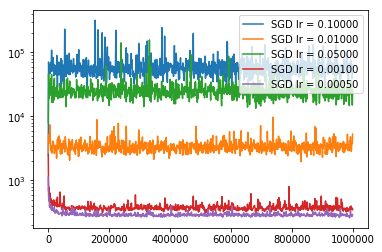

In [59]:
# plotting
for i in range(len(results)):
    sgd = results[i]
    plt.plot(sgd["iter"], sgd["objective_function"], label="SGD lr = {:1.5f}".format(lrs[i]))
    plt.yscale('log')
plt.legend()

It seems that the first 3 learning rates are too big. 
Repeat experiment with even smaller learning rates (lr <= 0.001):

In [61]:
lrs = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]
results = []
for lr in lrs:
    print('Running SGD with lr=', lr)
    sgd = stochastic_gradient_descent_svm_demo(A, y, lr, trace=True)
    results.append(sgd)
    print('---------------------------------------------')

Running SGD with lr= 0.001
iteration=0, primal:988.62016
iteration=100000, primal:349.17183
iteration=200000, primal:364.29257
iteration=300000, primal:369.87797
iteration=400000, primal:366.53268
iteration=500000, primal:377.20163
iteration=600000, primal:398.52138
iteration=700000, primal:357.86760
iteration=800000, primal:335.80020
iteration=900000, primal:411.15856
training accuracy = 0.9862737182075091
---------------------------------------------
Running SGD with lr= 0.0005
iteration=0, primal:2234.06902
iteration=100000, primal:283.66106
iteration=200000, primal:385.30826
iteration=300000, primal:284.98281
iteration=400000, primal:295.02302
iteration=500000, primal:290.33378
iteration=600000, primal:287.14758
iteration=700000, primal:287.17260
iteration=800000, primal:277.65706
iteration=900000, primal:304.45808
training accuracy = 0.9903108599111828
---------------------------------------------
Running SGD with lr= 0.0001
iteration=0, primal:2477.00000
iteration=100000, primal:

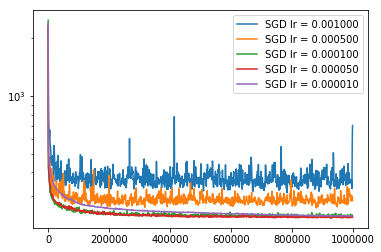

In [62]:
# plotting
for i in range(len(results)):
    sgd = results[i]
    plt.plot(sgd["iter"], sgd["objective_function"], label="SGD lr = {:f}".format(lrs[i]))
    plt.yscale('log')
plt.legend()

The best learning rates are 0.0001 with a training accuracy of 0.9951.

## Compare SGD with Coordinate Descent

Compare two algorithms in terms of convergence, time complexities per iteration. Which one is easier to use?

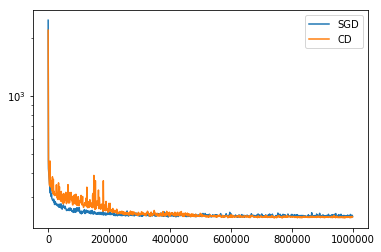

In [64]:
# plot CD and best SGD for comparison

#index of best lr
i = 2
plt.plot(results[i]["iter"], results[i]["objective_function"], label="SGD")
plt.plot(history_cd["iter"], history_cd["objective_function"], label="CD")
plt.yscale('log')
plt.legend()

We can observe that the convergence of CD is a bit not stable at the beginning. However, it manages to converge at nearly the same iteration as the SGD, even though for SGD we have tunned the learning rate. Both methods have the same time complexity per iteration.